In [1]:
import torch
import skripsi_program
from skripsi_program import SpectralSVR, to_complex_coeff, to_real_coeff, FourierBasis, LSSVR, scale_to_standard

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
generator = torch.Generator().manual_seed(42)
modes = [2]
prod_modes = 2
num_samples = 4000
k = FourierBasis.waveNumber(prod_modes)
u_coeff = FourierBasis.generateCoeff(num_samples, prod_modes, generator=generator)
ut_coeff = u_coeff * 2j * torch.pi * k.T / prod_modes
utt_coeff = ut_coeff * 2j * torch.pi * k.T / prod_modes # d2f/dt2
# u_coeff = u_coeff.reshape((-1, *modes))
# f_coeff = f_coeff.reshape((-1, *modes))
u_coeff.shape

torch.Size([4000, 2])

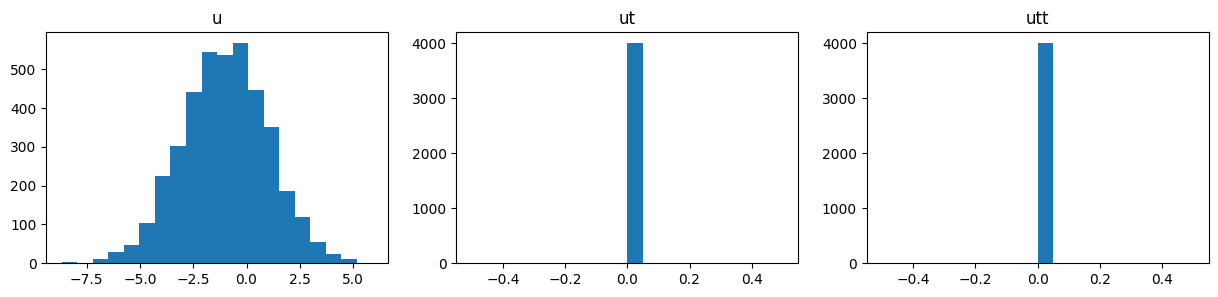

In [4]:
def visualize_dist_coeff(dim=0):
    fig, axs = plt.subplots(1, 3, figsize=[15,3])

    axs[0].hist(u_coeff[:,dim].real, bins = 20)
    axs[0].set_title("u")
    axs[1].hist(ut_coeff[:,dim].imag/8, bins = 20)
    axs[1].set_title("ut")
    axs[2].hist(utt_coeff[:,dim].real/32, bins = 20)
    axs[2].set_title("utt")
    plt.show()
visualize_dist_coeff(0)

In [6]:
sample_freq = 100.0
sample_step = 1.0 / sample_freq
periods = [1.0] * len(modes)
t = torch.arange(0, 1, sample_step)
tmp = [t for i in range(len(modes))]
tt = torch.meshgrid(tmp, indexing="ij")
points_tt = torch.concat([t.flatten().unsqueeze(-1) for t in tt], 1)
u_basis = FourierBasis(u_coeff, periods)
ut_basis = FourierBasis(ut_coeff, periods)
utt_basis = FourierBasis(utt_coeff, periods)
u = u_basis.evaluate(points_tt).real
ut = ut_basis.evaluate(points_tt).real
utt = utt_basis.evaluate(points_tt).real


In [7]:
u_shape = u.shape
u_shape

torch.Size([4000, 100])

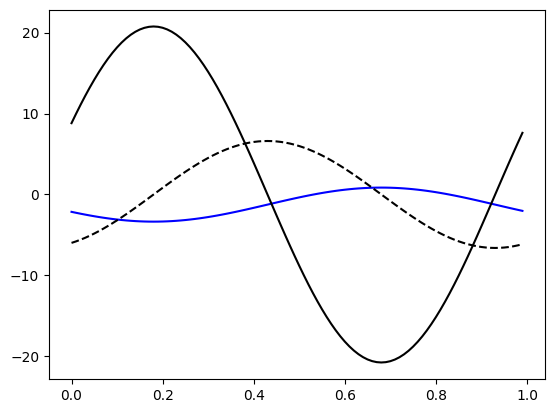

In [8]:
# fig, axs = plt.subplots(1,2,figsize=[15,2])
# for i in range(2):
plt.plot(t, u[2].real, color="b")
plt.plot(t, ut[2].real, color="k", linestyle="dashed")
plt.plot(t, utt[2].real, color="k")
# axs[0].plot(t, u[2].real)
# axs[0].set_title("function")
# axs[1].plot(t, f[2].real)
# axs[1].set_title("derivative")
plt.show()

In [20]:
# sample_indices = torch.randperm(num_samples, generator=generator)
# train_indices = sample_indices[:2000]
# test_indices = sample_indices[2000:]
# f_train = f_coeff[train_indices]
# f_train = f[train_indices]
# u_train = u[train_indices]
# u_coeff_train = u_coeff[train_indices]
# f_test = f[test_indices]
# u_test = u[test_indices]
# u_coeff_test = u_coeff[test_indices]
# f_test = f_coeff[test_indices]
# dataset = torch.utils.data.TensorDataset(f_coeff,u,u_coeff)
utt_scaled = scale_to_standard(utt)
utt_coeff_scaled = scale_to_standard(utt_coeff)
u_scaled = scale_to_standard(u)
u_coeff_scaled = scale_to_standard(u_coeff)
dataset = torch.utils.data.TensorDataset(
    utt_scaled, utt_coeff_scaled, u_scaled, u_coeff_scaled
)
dataset_train, dataset_test = torch.utils.data.random_split(dataset, (0.5, 0.5))
f_train, f_coeff_train, u_train, u_coeff_train = dataset_train[:]
f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[:]
f_train.shape, f_coeff_train.shape, u_coeff_train.shape


(torch.Size([2000, 100]), torch.Size([2000, 2]), torch.Size([2000, 2]))

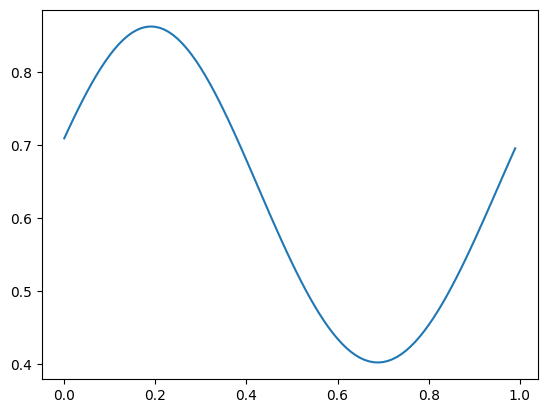

In [21]:
plt.plot(points_tt[:], u_train[0])
plt.show()

In [22]:
# model = SpectralSVR(FourierBasis(periods=periods), C=41.6207,sigma=4.0776, kernel="linear")
model = SpectralSVR(FourierBasis(periods=periods), C=1.0, sigma=1.0, kernel="rbf", verbose=False)

In [23]:
f_input_train = f_train
model.train(f_input_train, u_coeff_train, modes)
# lssvr.fit(points_sampled, u_sampled.T)

In [24]:
f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[4:10]
f_input_test = f_test
u_pred = model.forward(f_input_test, points_tt)
# u_pred = lssvr.predict(points_tt).T
u_pred.shape

torch.Size([6, 100])

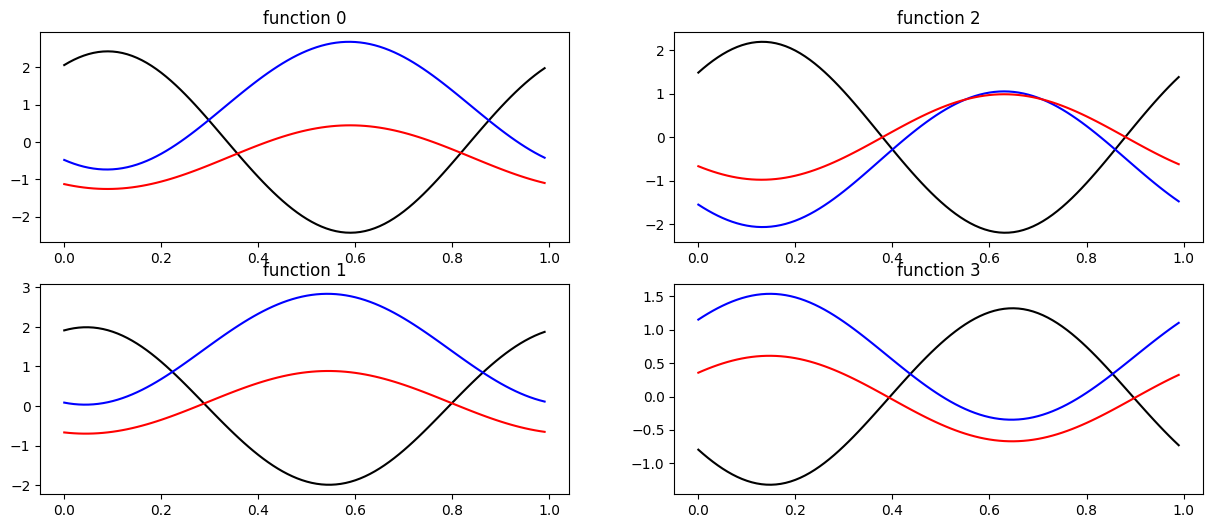

In [25]:
line_styles = ["solid", "dotted", "dashed", "dashdot"]
fig, axs = plt.subplots(2,2, figsize=[15,6])
for i, line_style in enumerate(line_styles):
    # axs[i%2, i//2].scatter(points_sampled[:,1], u_sampled[i, :])
    axs[i%2, i//2].plot(t, f_test[i].real, color="black")
    axs[i%2, i//2].plot(t, u_test[i].real, color="blue")
    axs[i%2, i//2].plot(t, u_pred[i].real, color='red')
    axs[i%2, i//2].set_title(f"function {i}")
    
plt.show()